In [1]:
import os
import numpy as np
import pandas as pd
import urllib.request
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage.segmentation import slic
from fast_slic import Slic
from sklearn.cluster import KMeans
from scipy.ndimage import label

from mmseg.datasets.transforms import *
from mmseg.datasets import PascalVOCDataset
from mmengine.structures import PixelData


from mmengine.config import Config, DictAction
from mmengine.runner import Runner
import itertools
import time

from modelscope import (
    snapshot_download, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
)

# torch.cuda.set_device('cuda:4')

2023-11-19 06:47:29,133 - modelscope - INFO - PyTorch version 1.13.1+cu117 Found.
2023-11-19 06:47:29,135 - modelscope - INFO - Loading ast index from /home/jy/.cache/modelscope/ast_indexer
2023-11-19 06:47:29,163 - modelscope - INFO - Loading done! Current index file version is 1.9.4, with md5 388dbad55e3820c5e27f291c18f2d2a1 and a total number of 945 components indexed


In [2]:
model_id = 'qwen/Qwen-VL-Chat'
revision = 'v1.0.0'
model_dir = '../Qwen-VL-Chat'
finetune_dir = '/remote-home/zhangjiacheng/Qwen-VL/output_qwen_attn'
model = AutoModelForCausalLM.from_pretrained(finetune_dir, device_map="cuda", trust_remote_code=True).eval()
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
if not hasattr(tokenizer, 'model_dir'):
    tokenizer.model_dir = model_dir

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Loading checkpoint shards: 100%|██████████| 10/10 [01:01<00:00,  6.10s/it]


In [4]:
feature_l = {}
handle = []
def hook_fn(layer_name, feature_l):
    def _hook_fn(m, fea_in, fea_out):
        feature_l[layer_name] = fea_out.detach().cpu()
    return _hook_fn

handle.append(model.transformer.visual.transformer.resblocks[10].register_forward_hook(hook_fn('10', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[20].register_forward_hook(hook_fn('20', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[30].register_forward_hook(hook_fn('30', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[40].register_forward_hook(hook_fn('40', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[47].register_forward_hook(hook_fn('47', feature_l)))

In [41]:
img_path = '/remote-home/zhangjiacheng/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_000727.jpg'
queries = ['<img>{}</img>Describe this image.'.format(img_path)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
history

["The scene is set in a busy city street during the day. There is a bus parked on the side of the road, and multiple people are walking around, some close to the bus and others further away. The street is filled with traffic, including cars and traffic lights. \n\nThere are several tall buildings surrounding the street, creating a bustling urban atmosphere. A large LG sign can be seen in the background, adding to the city's vibrant ambiance. Overall, it is a lively city scene with people going about their day."]

In [8]:
img_path = '/remote-home/zhangjiacheng/RVP/data/rendered_img/2007_000033/3.jpg'
prompt_template = '<img>{}</img> \
What is the most likely category of the object under the green glow? \
Choose your answer from this list: {}.'
queries = [prompt_template.format(img_path, classes_str)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
print (responses)

['aeroplane']


### 整理代码
空岛去除和空缺填补

In [42]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l['10'][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

/opt/conda/envs/mm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/opt/conda/envs/mm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


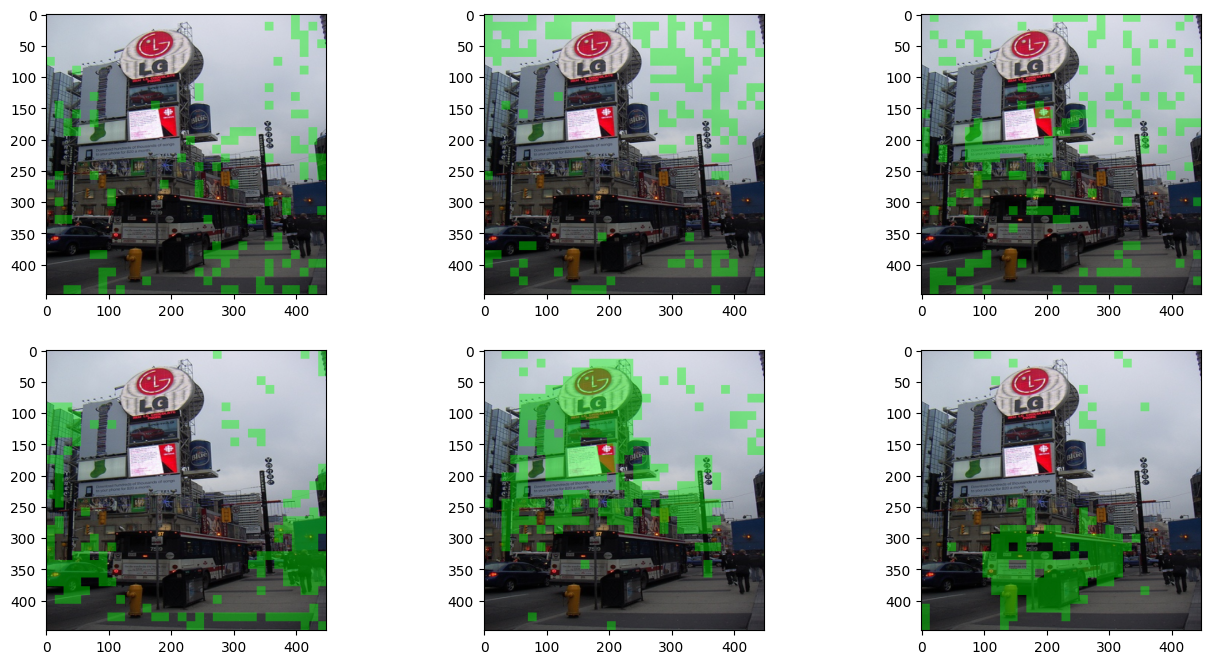

In [47]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l['47'][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

cluster_img = np.zeros((448, 448, 3))

for i in range(32):
    for j in range(32):
        patch_label = cluster_ids[i * 32 + j]
        # color = plt.cm.tab10(patch_label / 10)
        # cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = color[:3]
        cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = patch_label

# superpixels_masks.shape: (ids, C, H, W)
masks = []
for id in np.unique(cluster_ids):
    mask = (cluster_img == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks).permute(0, 3, 1, 2)

mask = cv2.imread(img_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = torch.tensor(mask.transpose(2, 0, 1))
img_repeated = T.Resize((448, 448))(mask)[None].expand_as(masks)

color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]) # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[masks] = img_repeated[masks]
remain_imgs[masks.logical_not()] = img_repeated[masks.logical_not()]

# Render images
# Mix-up (Background brightness unchanged)
color_mode = 'G'
if color_mode == 'R':
    rendered_imgs = (mask_imgs * 0.6 + masks * Red * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Red * 0.4
elif color_mode == 'G':
    rendered_imgs = (mask_imgs * 0.6 + masks * Green * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Green * 0.4
elif color_mode == 'B':
    rendered_imgs = (mask_imgs * 0.6 + masks * Blue * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Blue * 0.4
else:
    raise ValueError('Color not supported: {}'.format(color_mode))

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes[0, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
axes[0, 1].imshow(rendered_imgs[1].permute(1, 2, 0).cpu().to(torch.uint8))
axes[0, 2].imshow(rendered_imgs[2].permute(1, 2, 0).cpu().to(torch.uint8))
axes[1, 0].imshow(rendered_imgs[3].permute(1, 2, 0).cpu().to(torch.uint8))
axes[1, 1].imshow(rendered_imgs[4].permute(1, 2, 0).cpu().to(torch.uint8))
axes[1, 2].imshow(rendered_imgs[5].permute(1, 2, 0).cpu().to(torch.uint8))

In [15]:
cluster_ids = np.resize(cluster_ids, (32, 32))
print (cluster_ids.shape)

masks = []
for id in np.unique(cluster_ids):
    print (id)
    mask = (cluster_ids == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks)
pre_masks = masks.clone()
print (masks.shape)

(32, 32)
0
1
2
3
4
5
torch.Size([6, 32, 32])


In [10]:
structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

for mask in masks:
    print (mask.shape)
    l, n = label(mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 3:
            mask[lb == l] = 0
    
    reversed_mask = mask.logical_not()
    l, n = label(reversed_mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 10:
            # print (lbl)
            mask[lb == l] = 1

cluster_img = np.zeros((448, 448, 3))

mask = cv2.imread(img_path)
resized_masks = masks[:, None].repeat(1, 3, 1, 1)
resized_masks = TF.resize(resized_masks, (mask.shape[0], mask.shape[1]), interpolation=InterpolationMode.NEAREST)
resized_masks.shape

torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])


torch.Size([6, 3, 366, 500])

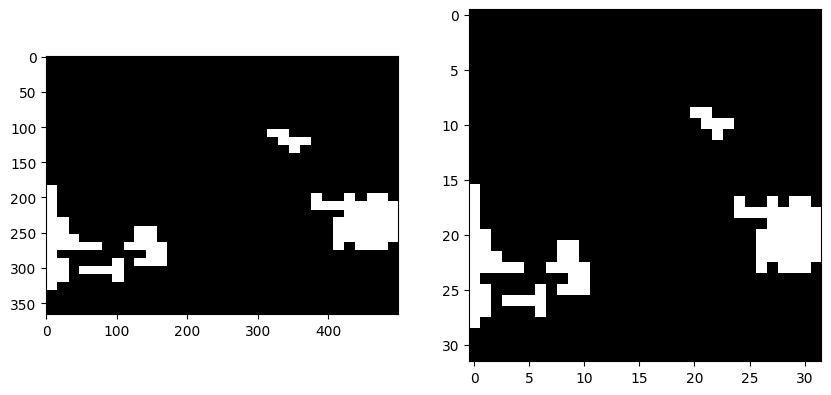

In [12]:
idx = 4
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
tmp = resized_masks[idx, 0]
axes[0].imshow(tmp, cmap='gray', interpolation='none')
axes[1].imshow(masks[idx], cmap='gray', interpolation='none')

In [ ]:
print (cluster_ids[..., None].shape)
np.tile(cluster_ids[..., None], (1, 1, 3)).shape

torch.Size([6, 3, 32, 32])
torch.Size([32, 32])
12


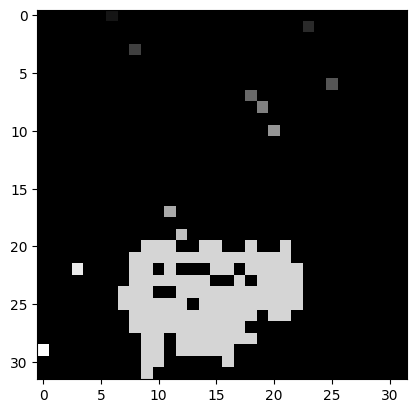

In [153]:
# masks.shape
# import torchvision.transforms.functional as TF
# resized = TF.resize(masks, (img.shape[1], img.shape[2]))
# resized = resized[0, 1].numpy()
# resized.shape


masks = []
for id in np.unique(cluster_ids):
    mask = (cluster_ids == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks).permute(0, 3, 1, 2)

structure = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]

structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

print (masks.shape)

def reconstruct_mask(mask):
    pass

a = np.array([[0,0,1,1,0,0],
              [0,0,0,1,0,0],
              [1,1,0,0,1,0],
              [0,0,0,1,0,0]])
l, n = label(masks[2, 0], structure=structure)
plt.imshow(l, cmap='gray', interpolation='none')

tmp = masks[2, 0]
print (tmp.shape)
for lbl in range(1, n + 1):
    if np.sum(lbl == l) <= 3:
        # print (lbl)
        masks[2, 0][lbl == l] = 0
print (n)

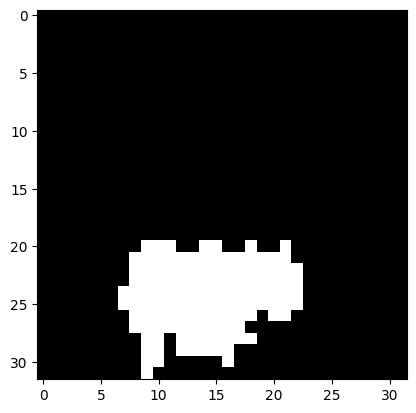

In [154]:
structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]
reversed_mask = masks[2, 0].logical_not()
l, n = label(reversed_mask, structure=structure)

for lbl in range(1, n + 1):
    if np.sum(lbl == l) <= 3:
        # print (lbl)
        masks[2, 0][lbl == l] = 1

plt.imshow(masks[2, 0], cmap='gray', interpolation='none')

In [2]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]) # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[masks] = img_repeated[masks]
remain_imgs[masks.logical_not()] = img_repeated[masks.logical_not()]

# Render images
# Mix-up (Background brightness unchanged)
color_mode = 'G'
if color_mode == 'R':
    rendered_imgs = (mask_imgs * 0.6 + masks * Red * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Red * 0.4
elif color_mode == 'G':
    rendered_imgs = (mask_imgs * 0.6 + masks * Green * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Green * 0.4
elif color_mode == 'B':
    rendered_imgs = (mask_imgs * 0.6 + masks * Blue * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Blue * 0.4
else:
    raise ValueError('Color not supported: {}'.format(color_mode))

NameError: name 'torch' is not defined

In [21]:
pred = cv2.imread('/remote-home/zhangjiacheng/RVP/data/sem_seg_preds/scikit30/G/2007_001175.jpg')
# pred = np.array(Image.open('/remote-home/zhangjiacheng/RVP/data/sem_seg_preds/scikit30/G/2007_001175.jpg'))
# print (pred.shape)
# print (pred[..., 0])
# for i in range(pred.shape[0]):
#     print (pred[i])
print (np.unique(pred))
pred1 = np.load('./test.npy')
print (np.unique(pred1))
pred1[None].shape

[ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0 18]


(1, 375, 500)

# GT测试

In [2]:
class SimulateArgs:
    def __init__(self):
        self.config = '../mmsegmentation/my_configs/pascal_voc12_base.py'
        self.launcher = 'none'
        self.cfg_options = None
        self.work_dir = None
        self.checkpoint = None
        self.tta = False
        self.out = None

args = SimulateArgs()


# load config
cfg = Config.fromfile(args.config)
cfg.launcher = args.launcher
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = os.path.join('./work_dirs',
                            os.path.splitext(os.path.basename(args.config))[0])

cfg.load_from = args.checkpoint

# if args.show or args.show_dir:
#     cfg = trigger_visualization_hook(cfg, args)

if args.tta:
    cfg.test_dataloader.dataset.pipeline = cfg.tta_pipeline
    cfg.tta_model.module = cfg.model
    cfg.model = cfg.tta_model

# add output_dir in metric
if args.out is not None:
    cfg.test_evaluator['output_dir'] = args.out
    cfg.test_evaluator['keep_results'] = True

In [3]:
runner = Runner.from_cfg(cfg)
loader = runner.val_dataloader
evaluator = runner.val_evaluator

runner.call_hook('before_val')
runner.call_hook('before_val_epoch')
runner.model.eval()

11/19 06:47:58 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.18 (main, Sep 11 2023, 13:41:44) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 1134241117
    GPU 0,1,2,3,4,5,6,7: Tesla V100S-PCIE-32GB
    CUDA_HOME: /home/jy/apps/cuda-11.7
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arc

/home/jy/mm/RVP/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


11/19 06:48:02 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
11/19 06:48:02 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): _BatchNormXd(64, eps=

In [4]:
data_sample = next(val_dataloader)
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
print (f'img shape: {img.shape}')

mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
# mask[mask == 255] = 0
# mask[mask != 0] = 1
mask[(mask < 255) & (mask != 0)] = 1
mask[mask == 255] = 0
mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()
print (f'mask shape: {mask.shape}')
print (f'mask unique: {torch.unique(mask)}')

mask_img = torch.zeros_like(img).cuda()
remain_img = torch.zeros_like(img).cuda()
mask_img[mask] = img[mask]
remain_img[mask.logical_not()] = img[mask.logical_not()]

# rendered_img = mask * Green * 0.4 + img * 0.6
rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
plt.imshow(rendered_img[0].permute(1, 2, 0).cpu().to(torch.uint8))

TypeError: 'DataLoader' object is not an iterator

### GT数据集伪造

In [4]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
os.makedirs('../data/voc_gt_modified', exist_ok=True)
for data_sample in loader:
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    resized_mask = TF.resize(gt_mask, (448, 448), interpolation=InterpolationMode.NEAREST)
    # resized_mask[(resized_mask < 255) & (resized_mask != 0)] = 1
    resized_mask[resized_mask == 255] = 0
    print (torch.unique(resized_mask))

    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
    
    save_dir_name = os.path.join('../data/voc_gt_modified', img_name)
    os.makedirs(save_dir_name, exist_ok=True)

    ## 按标签存
    for l in torch.unique(resized_mask):
        if (l == 0):
            continue
        label = l.item()
        
        ptr = torch.zeros(32, 32, dtype=torch.bool)
        ptr_mask = torch.rand(32, 32) < 0.06
        for i in range(32):
            for j in range(32):
                lbl = torch.unique(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14])
                if torch.any(lbl == label): 
                    ptr[i, j] = True
        ptr[ptr_mask] ^= True

        mask = TF.resize(ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
        mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

        mask_img = torch.zeros_like(img).cuda()
        remain_img = torch.zeros_like(img).cuda()
        mask_img[mask] = img[mask]
        remain_img[mask.logical_not()] = img[mask.logical_not()]

        # rendered_img = mask * Green * 0.4 + img * 0.6
        rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
        rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
        rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(os.path.join(save_dir_name, str(label)+'.jpg'), rendered_img)


tensor([0, 1])
tensor([ 0, 19])
tensor([0, 4])
tensor([ 0, 19])
tensor([ 0,  2, 15])
tensor([ 0, 17])
tensor([ 0, 20])
tensor([ 0, 15])
tensor([ 0, 13])
tensor([ 0,  5, 15])
tensor([ 0,  9, 18])
tensor([ 0, 10])
tensor([ 0, 10])
tensor([0, 4, 7])
tensor([ 0,  5, 20])
tensor([0, 2])
tensor([ 0, 15, 19])
tensor([ 0, 19])
tensor([ 0,  9, 16, 18])
tensor([0, 6, 7])
tensor([ 0, 17])
tensor([ 0,  6,  7, 15])
tensor([ 0,  5, 11, 15])
tensor([ 0, 13, 15])
tensor([ 0, 13, 15])
tensor([ 0,  9, 18])
tensor([ 0,  9, 11])
tensor([0, 4])
tensor([ 0, 11, 15])
tensor([ 0,  4, 15])
tensor([ 0, 17])
tensor([ 0,  5, 15])
tensor([ 0, 16, 18])
tensor([ 0, 15, 20])
tensor([ 0, 12])
tensor([ 0, 15])
tensor([0, 1])
tensor([0, 3])
tensor([ 0, 10])
tensor([ 0,  2, 15])
tensor([0, 7])
tensor([0, 1])
tensor([ 0,  5, 15, 16])
tensor([ 0, 15])
tensor([ 0, 11, 15, 16, 20])
tensor([ 0,  9, 18])
tensor([ 0, 18])
tensor([ 0, 15])
tensor([0, 1])
tensor([ 0,  5, 15, 18])
tensor([ 0, 13, 15])
tensor([0, 2])
tensor([ 0, 12

#### 构造json文件

In [6]:
classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
        'sofa', 'train', 'tvmonitor']
classes_str = ""
for name in classes:
    classes_str += (name + ", ")
classes_str = classes_str[:-2]

name2id, id2name = dict(), dict()

for id, class_name in enumerate(classes):
    name2id[class_name] = id
    id2name[id] = class_name

In [7]:
prompt_template = '<img>{}</img> \
What is the most likely category of the object under the green glow? \
Choose your answer from this list: {}.'
json_list = []
basedir = '/home/jy/mm/RVP/data/voc_gt_modified'
imgdirs = os.listdir(basedir)
cnt = 0
for img_name in imgdirs:
    imgdir = os.path.join(basedir, img_name)
    img_names = os.listdir(imgdir)
    for img_name in img_names:
        id = int(img_name.split('.')[0])
        img_path = os.path.join(imgdir, img_name)
        dic = {
            "id": "identity_{}".format(cnt),
            "conversations": [
                {
                    "from": "user",
                    "value": prompt_template.format(img_path, classes_str)
                },
                {
                    "from": "assistant",
                    "value": "{}".format(id2name[id])
                }
            ]
        }
        cnt += 1
        json_list.append(dic)

with open('data.json', 'w') as file:
    json.dump(json_list, file, indent=4)

tensor([  0,  13,  15, 255])
tensor([  0,  13,  15, 255])
torch.Size([1, 441, 500])


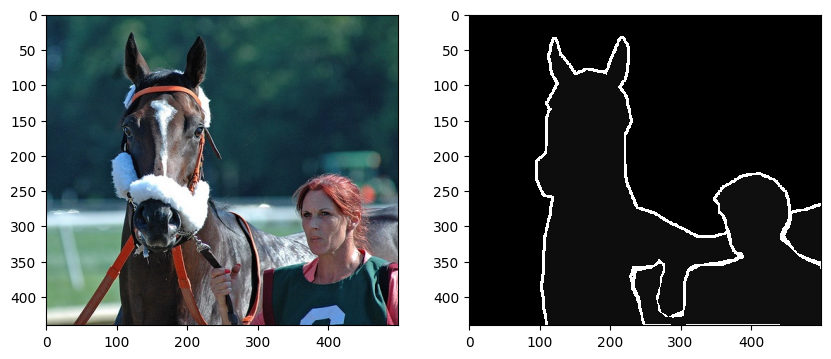

In [36]:
data_sample = next(val_dataloader)
img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
print (torch.unique(mask))
# mask[(mask < 255) & (mask != 0)] = 1
print (torch.unique(mask))
print (mask.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[1].imshow(mask[0], cmap='gray', interpolation='none')


In [32]:
# 使用pandas读取TSV文件
data = pd.read_csv('../data/cc12m.tsv', sep='\t', header=None)

In [ ]:
random_data = data.sample(n=2000, random_state=1234)
random_data.iloc[0][0]
random_data.columns = ['website', 'caption']

In [2]:
data = pd.read_csv('cc12.csv')
if not os.path.exists('../data/cc12'):
    os.makedirs('../data/cc12')

failed_list = []
for idx, row in data.iterrows():
    url = row['website']
    print (f'{idx}: {url}')
    
    try:
        img_response = urllib.request.urlopen(url)
        img_array = np.array(bytearray(img_response.read()), dtype=np.uint8)
        img = cv2.imdecode(img_array, -1)
        
        file_path = os.path.join('../data/cc12', '{}.jpg'.format(idx))
        cv2.imwrite(file_path, img)
    except:
        failed_list.append(idx)
print (failed_list)

0: https://cdn-ssl.s7.disneystore.com/is/image/DisneyShopping/3061047091080-5
1: https://i.pinimg.com/originals/3e/29/e7/3e29e70417a736bc59dc6209a1cebe37.jpg
2: https://ih1.redbubble.net/image.6926765.4094/poster,504x498,f8f8f8-pad,600x600,f8f8f8.u4.jpg
3: https://media.gettyimages.com/photos/cate-blanchett-and-andrew-upton-attend-the-oceans-8-uk-premiere-held-picture-id973249734?s=612x612
4: http://backpackingforbeginners.com/wp-content/uploads/2019/02/11-Kuta-1024x637.jpg
5: https://i.pinimg.com/originals/0b/be/ba/0bbeba6fe73019c6e660358f97586beb.jpg
6: https://grimytee.s3.us-east-2.amazonaws.com/Bob-the-Midlife-Crisis-Hamster-Shirt
7: https://i.pinimg.com/originals/ba/59/8c/ba598c002cf9b8b4cb30d41ca2052f3a.jpg
8: https://static1.squarespace.com/static/5a4a74508dd0413edd3548e0/5a4a8704f9619ae3bb7e982d/5c070866575d1f3fc21b4a26/1555823688118/Tidy+cable+routing.jpg?format=1000w
9: https://www.gannett-cdn.com/-mm-/ae3b2215843bf24557014e93264d2d99dc86354d/c=132-0-2255-1592/local/-/media/2